In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Names and PRN for all group members:
- Name: ______________________
- PRN:  ______________________
- Date: ______________________

# Deep Neural Networks
## A07: Group Assignment


##  Convolutional Neural Network (CNN)

- Flowers Dataset


In [4]:
###-----------------
### Import Libraries
###-----------------
import os
import gc
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

parent_dir = os.path.abspath('..')
sys.path.insert(0, parent_dir)


from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix, fn_plot_label
from utils.configuration import Config

In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = os.path.join('..', 'input')
outDir = '../output'
modelDir = '../models'
subDir = 'flower_photos'
altName = 'base_model'


EPOCHS = 100
ALPHA = .001
TEST_SIZE = .2
BATCH_SIZE = 32
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)
IMG_WIDTH = 200
IMG_HEIGHT = 200



FLIP_MODE = 'horizontal_and_vertical'
ROTATION_FACTOR = (-.1, .1)
FILL_MODE = 'nearest'


# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)

In [6]:
data_dir = os.path.join(inpDir, subDir)
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [7]:
IMG_HEIGHT = 188
IMG_WIDTH = 188

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [9]:
'''
    For reading from web link
'''

#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
#data_dir = pathlib.Path(data_dir)
'''
    For reading from local directory
'''
data_dir = os.path.join(inpDir, subDir)

In [10]:
# use f1 score to tune

In [11]:
data_dir = os.path.join(inpDir, subDir)
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [12]:
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                                seed = RANDOM_STATE,
                                                                subset = 'training',
                                                                validation_split = TEST_SIZE)

test_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                                seed = RANDOM_STATE,
                                                                subset = 'validation',
                                                                validation_split = TEST_SIZE)
                                                                

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
# is it getting the class names
class_names = train_ds.class_names
num_classes = len(class_names)
display(class_names, num_classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

5

In [14]:
class_name = {0:'daisy', 1:'dandelion', 2:'roses', 3:'sunflowers', 4:'tulips'}

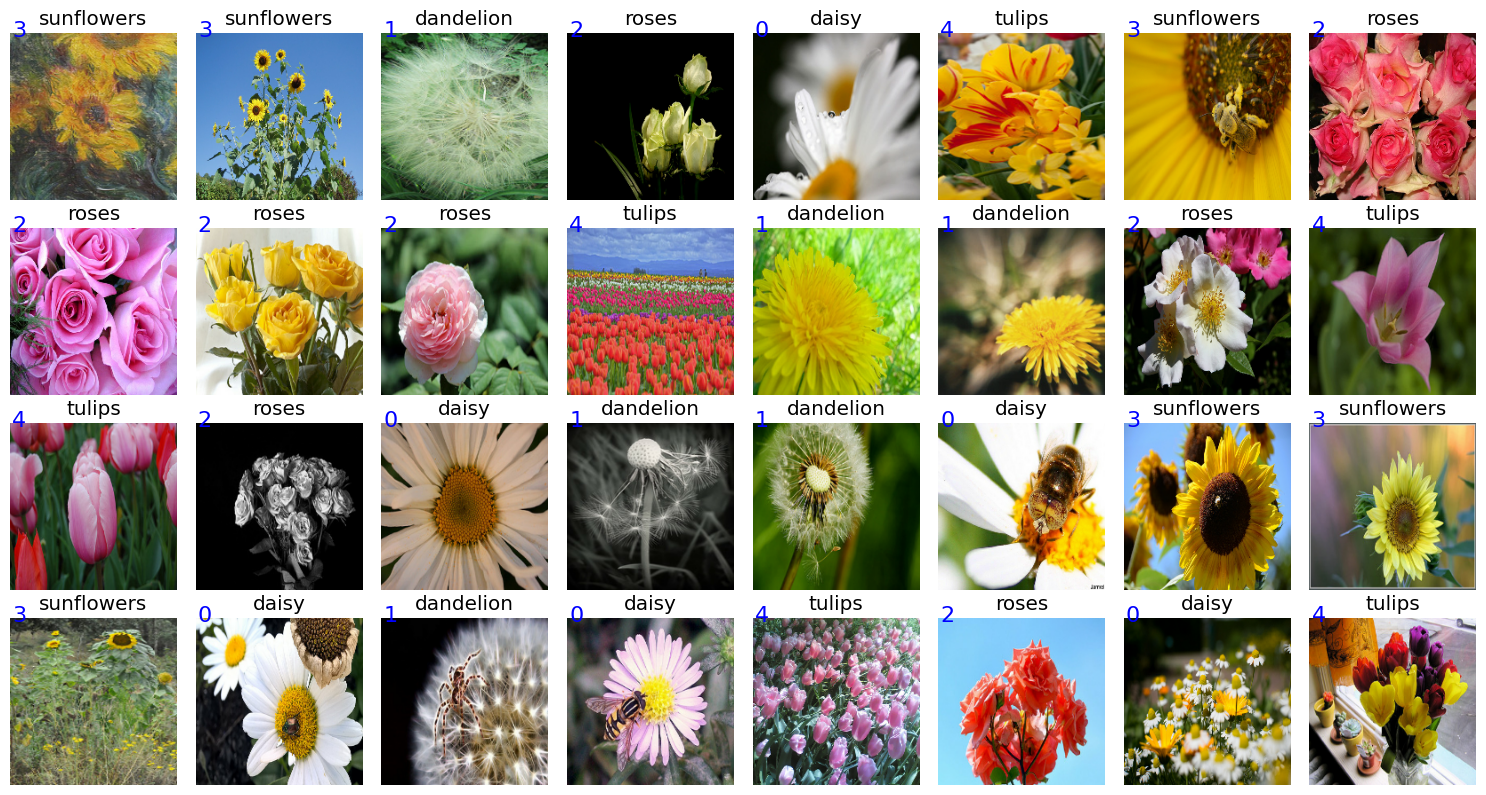

In [15]:
for images, labels in train_ds.take(1):

    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE//8, 8 ,i+1)

        plt.grid(False)

        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary)

        # add the class nameof the image in red text above the numeric label
        plt.title(class_names[labels[i].numpy()])

        # add the numeric label of the image in blue text at a specific position
        plt.text(2, 4, labels[i].numpy(), color = 'b', fontsize = 16)

        # switching off axis
        plt.axis('off')
    plt.tight_layout()
    #display the entire grid of image
    plt.show()


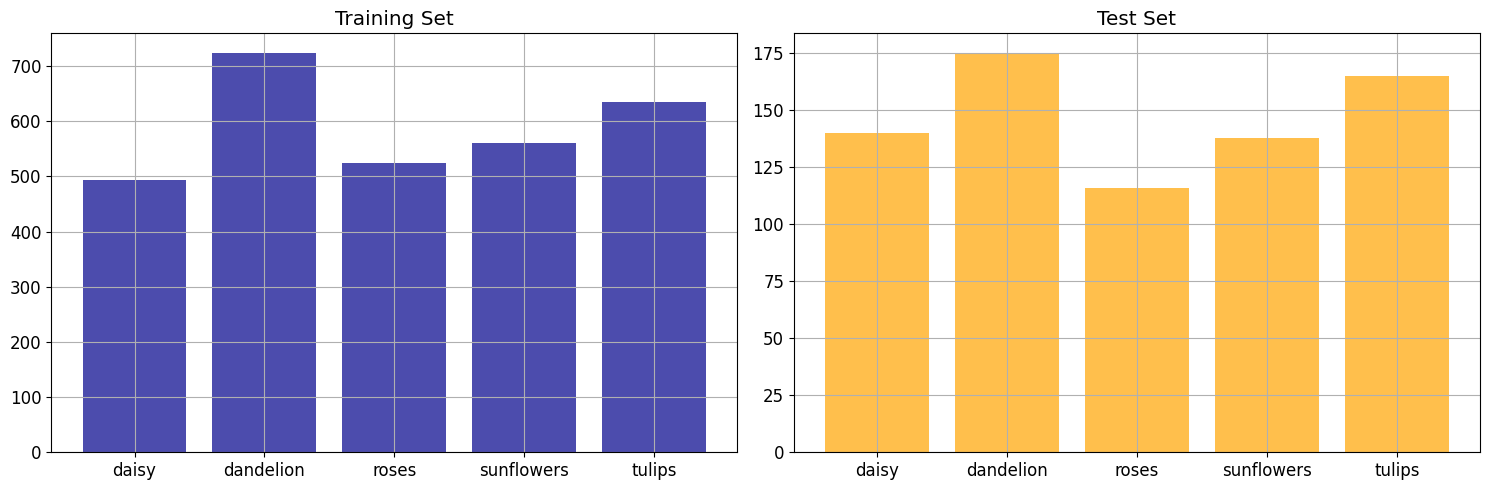

In [16]:
fn_plot_label(train_ds, test_ds)

In [17]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

## DATA AUGMENTAION

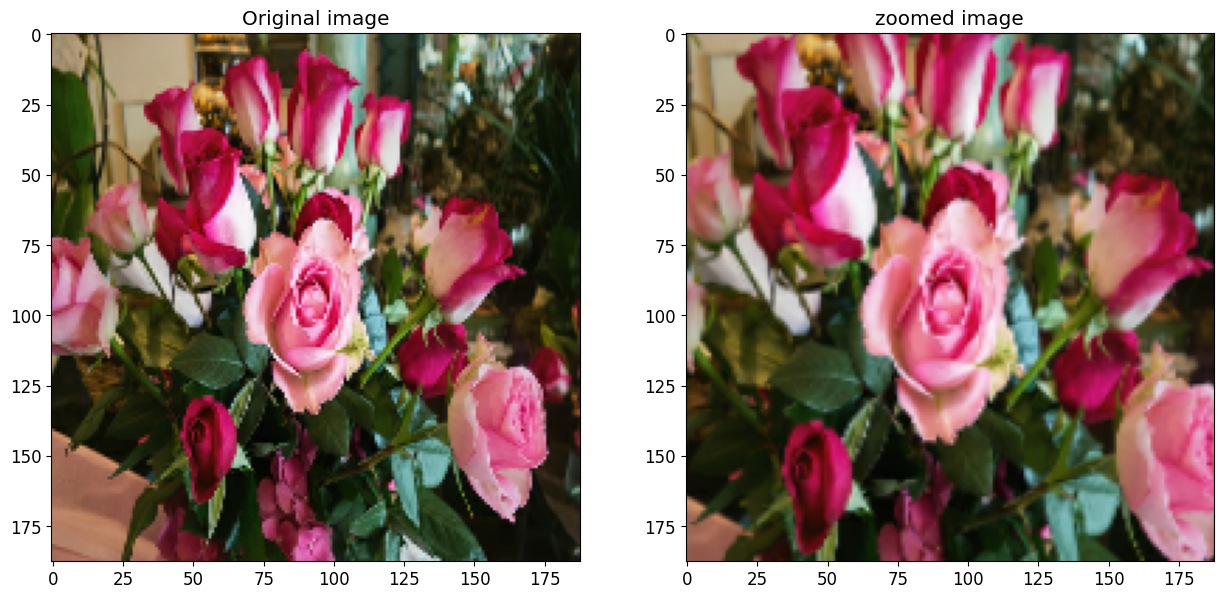

In [19]:
layer = tf.keras.layers.RandomZoom(height_factor = (-.2, -.2),
                                    width_factor= (-.2, -.2),
                                    seed=None,

)
plt.figure()

img_num = 1

for imgs, lbls in train_ds.take(1):
    out_image = layer(imgs)
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(imgs[img_num].numpy().astype('uint8')) # The method astype('uint8') converts the image data to the uint8 (unsigned 8-bit integer) type.

    plt.subplot(1, 2, 2)
    plt.title('zoomed image')
    plt.imshow(out_image[img_num].numpy().astype('uint8'))

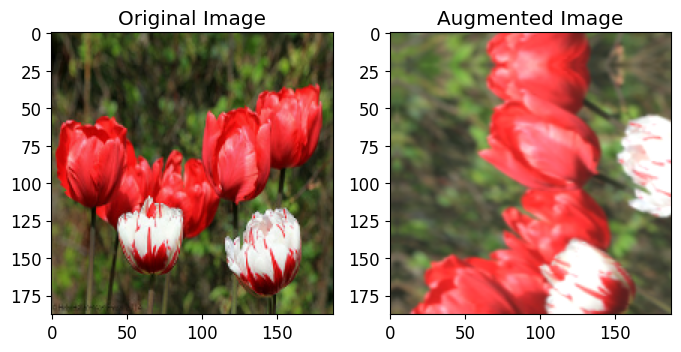

In [20]:
plt.figure(figsize=(8, 4))

img_num = 0  # Index of the image you want to display

# Set the random seed for deterministic results
random_seed = 24

# Define augmentation layers with a fixed seed for deterministic output
random_rotation = tf.keras.layers.RandomRotation(0.3, seed=random_seed)  # Random Rotation
random_zoom = tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.2), width_factor=(-0.2, -0.2), seed=random_seed)  # Random Zoom
random_shift = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=random_seed)  # Random Translation
random_flip = tf.keras.layers.RandomFlip("horizontal", seed=random_seed)  # Horizontal Flip
brightness = tf.keras.layers.RandomBrightness(0.2, seed=random_seed)  # Random Brightness

# Get one batch from the dataset
for imgs, lbls in train_ds.take(1):
    original_image = imgs[img_num].numpy().astype('uint8')

    # Apply augmentations one by one using the defined layers
    augmented_image = random_rotation(original_image)
    augmented_image = random_zoom(augmented_image)
    augmented_image = random_shift(augmented_image)
    augmented_image = random_flip(augmented_image)
    augmented_image = brightness(augmented_image)

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)  # Convert image to uint8 for display

    # Display the augmented image
    plt.subplot(1, 2, 2)
    plt.title('Augmented Image')
    plt.imshow(augmented_image.numpy().astype('uint8'))  # Convert augmented image to uint8

plt.show()

In [21]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomRotation(0.3, seed=RANDOM_SEED)  # Random Rotation
#     tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.2), width_factor=(-0.2, -0.2), seed=RANDOM_SEED)  # Random Zoom
#     tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=RANDOM_SEED)  # Random Translation
#     tf.keras.layers.RandomFlip("horizontal", seed=RANDOM_SEED)  # Horizontal Flip
#     tf.keras.layers.RandomBrightness(0.2, seed=RANDOM_SEED)  # Random Brightness

SyntaxError: '[' was never closed (418685524.py, line 1)

In [ ]:
def augment(imgs, lbls):
    random_seed = 24

    # Define augmentation layers with a fixed seed for deterministic output
    random_rotation = tf.keras.layers.RandomRotation(0.3, seed=random_seed)  # Random Rotation
    random_zoom = tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.2), width_factor=(-0.2, -0.2), seed=random_seed)  # Random Zoom
    random_shift = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=random_seed)  # Random Translation
    random_flip = tf.keras.layers.RandomFlip("horizontal", seed=random_seed)  # Horizontal Flip
    brightness = tf.keras.layers.RandomBrightness(0.2, seed=random_seed)  # Random Brightness


    
    augmented_image = random_rotation(imgs)
    augmented_image = random_zoom(augmented_image)
    augmented_image = random_shift(augmented_image)
    augmented_image = random_flip(augmented_image)
    augmented_image = brightness(augmented_image)

    return augmented_image, lbls

In [ ]:
layer = tf.keras.layers.RandomRotation(
                                        (-.5,.5), # (-0.5, 0.5) specifies the random range of rotation in radians.
                                        fill_mode='nearest', #  fills the empty space after rotation by using the nearest pixel value.
                                        seed=RANDOM_STATE, )
plt.figure()

img_num = 1

for imgs, lbls in train_ds.take(1):
    out_image = layer(imgs)
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(imgs[img_num].numpy().astype('uint8')) # The method astype('uint8') converts the image data to the uint8 (unsigned 8-bit integer) type.

    plt.subplot(1, 2, 2)
    plt.title('rotated image')
    plt.imshow(out_image[img_num].numpy().astype('uint8'))

#### PREPROCESSING DATA

In [40]:
#### PREPROCESSING DATA
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

##### later

In [ ]:
krnl_initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)
# krnl_reg = tf.keras.regularizers.L2(l2 = 0.01)
input_shape = (28, 28, 1)

dor1 = .1
dor2 = .2
dor3 = .3
dor4 = .4
dor5 = .4
dor6 = .4
dor7 = .4

inputs = tf.keras.Input(shape = input_shape, name = 'input')

x = tf.keras.layers.Rescaling(1./255.)(inputs)

# conv1

x = tf.keras.layers.Conv2D(32, (3,3),
                           kernel_initializer = krnl_initializer,
                           # kernel_regularizer = krnl_reg,
                           padding = 'same',
                           # activation = tf.keras.activations.relu,
                           name = 'conv_1')(x)  # (188, 188, 32)
# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

x =tf.keras.layers.Dropout(dor1)(x)
# max pool

x = tf.keras.layers.MaxPool2D((2, 2), (2, 2), name = 'mp_1')(x) #( 94 x 94 x 32)

# conv2

x = tf.keras.layers.Conv2D(64, (3,3),
                           kernel_initializer = krnl_initializer,
                           # kernel_regularizer = krnl_reg,
                           padding = 'valid',
                           # activation = tf.keras.activations.relu,
                           name = 'conv_2')(x)  # (92, 92, 64)

# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

x =tf.keras.layers.Dropout(dor2)(x)

# max pool

x = tf.keras.layers.MaxPool2D(name = 'mp_2')(x) #( 46 x 46 x 64) # default filter size is '2 x 2' and default stride is None:- if None then stride will be same as the shape of filter


##set3##
 # conv 3
x  = tf.keras.layers.Conv2D(128, (3,3), 
                            kernel_initializer = krnl_initializer,
                            # kernel_regularizer = krnl_reg,
                            # activation = tf.keras.activations.relu,
                            name = 'conv_3')(x) # (44 x 44 x 128)

# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

x =tf.keras.layers.Dropout(dor3)(x)

# max pool

x = tf.keras.layers.MaxPool2D(name = 'mp_3')(x) #( 22 x 22 x 128) # default filter size is '2 x 2' and default stride is None:- if None then stride will be same as the shape of filter


##set4##
 # conv 4
x  = tf.keras.layers.Conv2D(256, (3,3), 
                            kernel_initializer = krnl_initializer,
                            # kernel_regularizer = krnl_reg,
                            # activation = tf.keras.activations.relu,
                            name = 'conv_4')(x) # (20 x 20 x 256)

# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

x =tf.keras.layers.Dropout(dor4)(x)

# max pool

x = tf.keras.layers.MaxPool2D(name = 'mp_4')(x) #( 10 x 10 x 10) # default filter size is '2 x 2' and default stride is None:- if None then stride will be same as the shape of filter


##set5##
 # conv 5
x  = tf.keras.layers.Conv2D(512, (3,3), 
                            kernel_initializer = krnl_initializer,
                            # kernel_regularizer = krnl_reg,
                            # activation = tf.keras.activations.relu,
                            name = 'conv_5')(x) # (8 x 8 x 512)

# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

x =tf.keras.layers.Dropout(dor5)(x)

# max pool

x = tf.keras.layers.MaxPool2D(name = 'mp_5')(x) #( 4 x 4 x 512) # default filter size is '2 x 2' and default stride is None:- if None then stride will be same as the shape of filter


##set5##
 # conv 5
x  = tf.keras.layers.Conv2D(1024, (3,3), 
                            kernel_initializer = krnl_initializer,
                            # kernel_regularizer = krnl_reg,
                            # activation = tf.keras.activations.relu,
                            name = 'conv_5')(x) # (2 x 2 x 1024)

# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

x =tf.keras.layers.Dropout(dor6)(x)


# flattning layer
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, name = 'fc_1',
                          # kernel_regularizer = krnl_reg,
                          # activation = tf.keras.activations.relu
                         )(x)

# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

x =tf.keras.layers.Dropout(dor7)(x)

outputs = tf.keras.layers.Dense(10, name = 'output')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'MNIST')                                                   

### Model

In [38]:
densenet_model = tf.keras.applications.DenseNet169(weights = 'imagenet',
                                                    include_top = False, #  if include_top is False (the input shape has to be (224, 224, 3)
                                                   input_shape = input_shape)


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [43]:
for layer in densenet_model.layers:
    print(layer)

<InputLayer name=input_layer, built=True>
<ZeroPadding2D name=zero_padding2d, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=zero_padding2d_1, built=True>
<MaxPooling2D name=pool1, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<Activation name=conv2_block1_0_relu, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<Concatenate name=conv2_block1_concat, built=True>
<BatchNormalization name=conv2_block2_0_bn, built=True>
<Activation name=conv2_block2_0_relu, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Activation name=conv2_block2_1_relu, built=True>
<Conv2D name=conv2_block2_2_conv, built=True>
<Concatenate name=conv2_block2_concat,

In [45]:
for layer in densenet_model.layers:
    layer.trainable = False # makes sure the model stays with th eweigths with which it was downladed and not update those weights 

In [47]:
densenet_model.summary()

Model: "densenet169"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 188, 188,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 194, 194,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 94, 94,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 94, 94,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 94, 94,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 96, 96,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 47, 47,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 47, 47,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 47, 47,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 47, 47,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 47, 47,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 47, 47,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 47, 47,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 47, 47,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 47, 47,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 47, 47,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 47, 47,    │     12,288 │ conv2_block2_0_r

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,642,880 (48.23 MB)

In [49]:
num_classes = len(class_names)
num_classes 

5

In [61]:
def build_model(d_model, n_classes):
    krnl_initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Rescaling(1./255.))

    model.add(d_model) # 6 x6 x 1664

    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(1024, name = 'fc_1',
                              # kernel_regularizer = krnl_reg,
                              # activation = tf.keras.activations.relu
                             ))
    
    
    
    # activation
    model.add(tf.keras.layers.ReLU())
    
    
    model.add(tf.keras.layers.Dense(n_classes, name = 'output'))
    
    
    return model

In [65]:
model = build_model(densenet_model, num_classes)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 5, 5, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,642,880 (48.23 MB)

In [67]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [69]:
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)
model.compile(optimizer = optimizer, loss = loss_fn, metrics = ['accuracy'])

In [71]:
epochs = 0
chkptFilePath = os.path.join(modelDir, subDir, f'cnn_architecture{epochs}.weights.h5')
PATIENCE = 10
LR_FACTOR= .1
LR_PATIENCE = 5
mcb = tf.keras.callbacks.ModelCheckpoint(chkptFilePath,
                                         monitor = 'val_loss',
                                        verbose = 1,
                                        save_best_only = True,
                                        save_weights_only = True)

escb = tf.keras.callbacks.EarlyStopping(patience = PATIENCE,
                                 verbose =1,
                                 restore_best_weights = True)

lrcb = tf.keras.callbacks.ReduceLROnPlateau(factor = LR_FACTOR,
                                            patience = LR_PATIENCE,
                                            verbose = 1)
                                            

In [73]:
history = model.fit(train_ds, validation_data= test_ds, epochs = EPOCHS, verbose = 1, callbacks = [mcb, escb, lrcb]
                   )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6192 - loss: 14.5878
Epoch 1: val_loss improved from inf to 0.60699, saving model to ../models\flower_photos\cnn_architecture0.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.6207 - loss: 14.4885 - val_accuracy: 0.8460 - val_loss: 0.6070 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9212 - loss: 0.2937
Epoch 2: val_loss did not improve from 0.60699
92/92 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9212 - loss: 0.2937 - val_accuracy: 0.8025 - val_loss: 1.2260 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9417 - loss: 0.2089
Epoch 3: val_loss improved from 0.60699 to 0.53606, saving model to ../models\flower_photos\cnn_architecture0.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.9417 - loss: 0.2091 - val_accuracy: 0.9101 - val_loss: 0.5361 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [ ]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax() # new model (prediction only) = original model+ softmax
    ])
y_true, y_pred = [], []
for feat, lbls in train_ds:
    pred = prediction_model(feat).numpy()
    pred = pred.argmax(axis = 1)
    y_true.extend(lbls)
    y_pred.extend(pred)

len(y_true), len(y_pred)

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average = "weighted")

### Reload best Weights for evaluation

In [ ]:
class_names

### Evaluate the model

## Validate on the validation set